In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

#import warnings
#warnings.filterwarnings("ignore")

/tmp/ipykernel_74904/1012197530.py:27: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [3]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  plt.savefig("embeddings.{}.png".format(title), dpi=600)
  plt.show()
  return vecs_2d

### Data loading & processing

In [4]:
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

### Load word vectors

In [5]:
# 150k top vectors (with gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")


### Collect biased words

In [6]:
num_vectors_per_class = 7500

by_pca = False
if by_pca:
    pairs = [("male", "female"), ("masculine", "feminine"), ("he", "she"), ("him", "her")]
    gender_vecs = [model[p[0]] - model[p[1]] for p in pairs]
    pca = PCA(n_components=1)
    pca.fit(gender_vecs)
    gender_direction = pca.components_[0]
    
else:
    gender_direction = model["he"]-model["she"] 


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:50])
#print("LAST MASC")
#print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:50])
#print("LAST FEM")
#print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:50])


TOP MASC
('drafted', 'qb', 'soriano', 'himself', 'cardinals', 'giants', 'he', 'bullpen', 'sabean', 'jagr', 'muhammad', 'alou', 'rangers', 'defensive', 'draft', 'belichick', 'rookie', 'ratzinger', 'obp', 'santonio', 'muhammed', 'yankees', 'outfielder', 'preached', 'playmaker', 'lineman', 'offensive', 'wr', 'steelers', 'redskins', 'rushers', 'his', 'punter', 'anquan', 'boldin', 'bochy', 'caesarea', 'nfl', 'umenyiora', 'laurinaitis', 'flacco', 'rc', 'eusebius', 'packers', 'lhp', 'homers', 'mitre', 'linebacker', 'rhp', 'manny')
-------------------------
TOP FEM
('nichole', 'ftv', 'renee', 'sophie', 'christina', 'marie', 'pregnant', 'nicole', 'samantha', 'denise', 'sassy', 'madeline', 'alicia', 'lynette', 'xoxo', 'melanie', 'michelle', 'missy', 'kimberly', 'melissa', 'kayla', 'angelina', 'kristin', 'jennifer', 'emma', 'katie', 'pregnancy', 'jessica', 'heidi', 'tina', 'mandy', 'erika', 'maggie', 'shes', 'elaine', 'julie', 'vanessa', 'actress', 'leanne', 'kristina', 'faye', 'alexandra', 'tany

In [7]:
print(masc_scores[:10])
print(masc_scores[-10:])
print(neut_scores[:10])

(0.3077116310596466, 0.2944546043872833, 0.2902606725692749, 0.2880436182022095, 0.28346991539001465, 0.2792784869670868, 0.27867889404296875, 0.2778513431549072, 0.2777227759361267, 0.2761598527431488)
(0.12253306806087494, 0.1225176602602005, 0.1225091814994812, 0.12250387668609619, 0.12250122427940369, 0.12250054627656937, 0.12249962985515594, 0.12249766290187836, 0.12249290943145752, 0.12249205261468887)
(0.029992904514074326, 0.029986433684825897, 0.029980666935443878, 0.029979921877384186, 0.029978614300489426, 0.029952101409435272, 0.0299292653799057, 0.029928453266620636, 0.029928240925073624, 0.029922407120466232)


### Perform train-dev-test split

In [8]:
random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 10765; Dev size: 4614; Test size: 6592


### Debias

In [9]:
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 34, accuracy: 0.33029908972691807: 100%|██| 35/35 [00:37<00:00,  1.06s/it]


In [10]:
np.save("P.glove.dim=300.iters=35.npy", P)

### Test the quality of the debiasing.

#### Perform t-sne

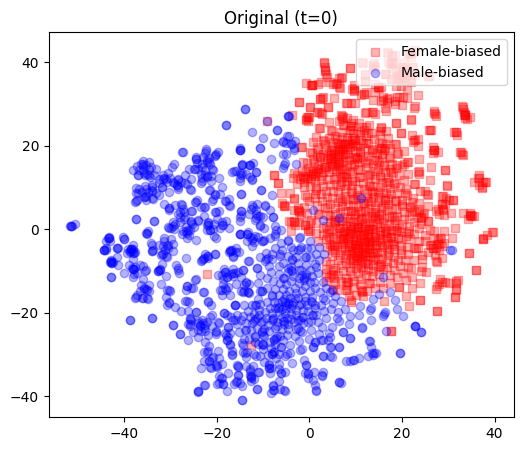

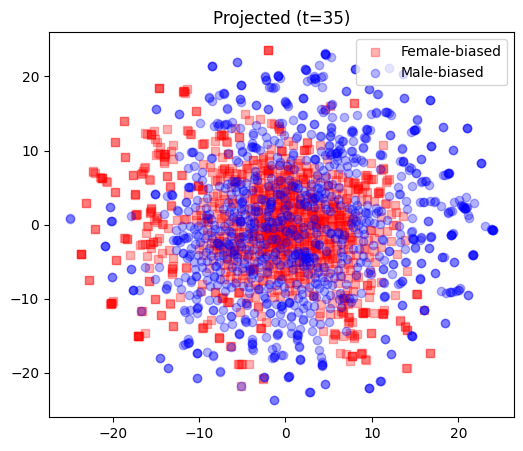

/Users/evar/mambaforge/envs/null_space/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/evar/mambaforge/envs/null_space/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/evar/mambaforge/envs/null_space/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


V-measure-before (TSNE space): 0.7397193021116673
V-measure-after (TSNE space): 0.005218645191661351
V-measure-before (original space): 1.0


/Users/evar/mambaforge/envs/null_space/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


V-measure-after (original space): 0.002028565321837549
Rank before: 300; Rank after: 210


In [11]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)
    

# remove neutral class, keep only male and female biased

X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M =  2000
ind2label =  {1: "Male-biased", 0: "Female-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )


X_dev_cleaned = (P.dot(X_dev.T)).T 
X_test_cleaned = (P.dot(X_test.T)).T 
X_trained_cleaned = (P.dot(X_train.T)).T 
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t={})".format(n), ind2label =ind2label )

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

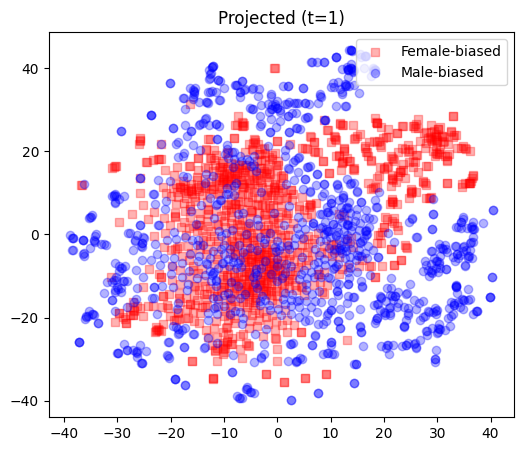

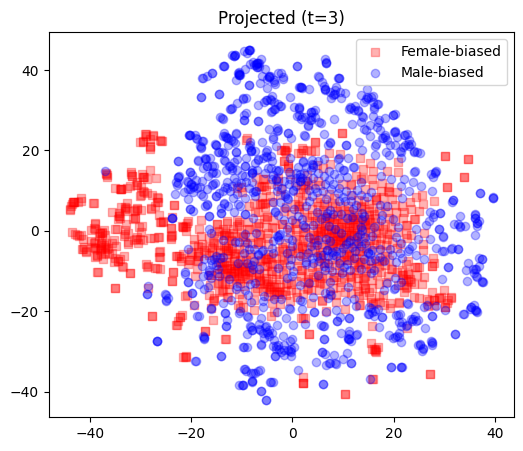

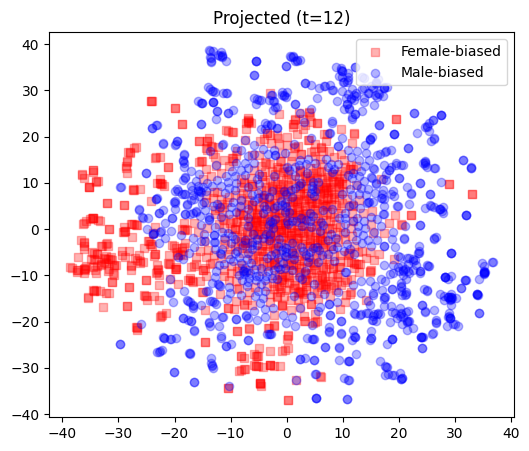

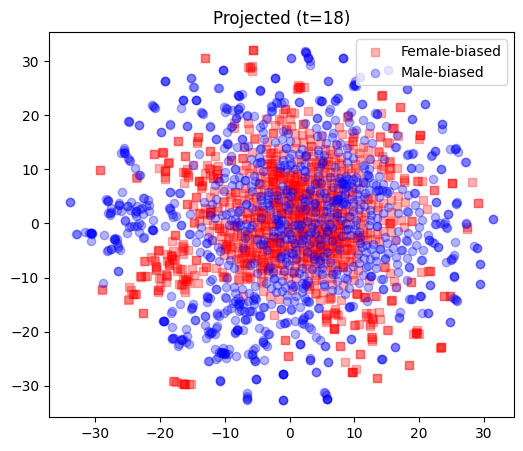

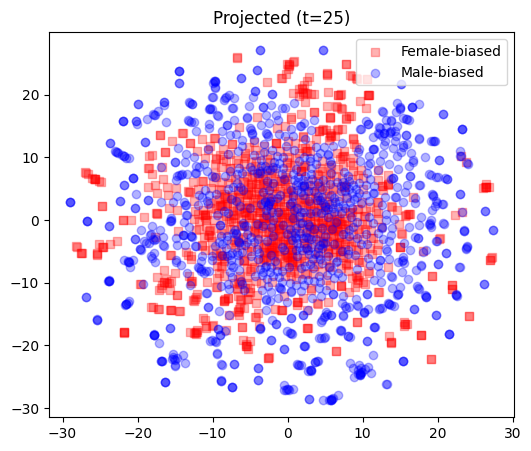

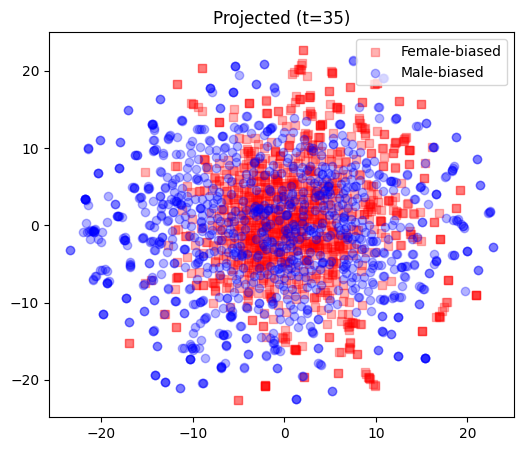

In [12]:
for t in [1,3,12,18,25,35]:
    p = debias.get_projection_to_intersection_of_nullspaces(rowspace_projs[:t], 300)
    tsne_after = tsne(p.dot(all_significantly_biased_vecs[:M].T).T, all_significantly_biased_labels[:M], title = "Projected (t={})".format(t), ind2label =ind2label )

## increase the gender component (not in the paper)

In [13]:

for word in ["quality", "mathematics", "red", "bag", "draft", "fashion", "nurse", "teacher",
            "talk", "book"]:
    v_word = model[word]
    P_rowspace = debias.get_rowspace_projection(Ws[1]) #np.eye(P.shape[0]) - P
    P_rowspace = np.eye(P.shape[0]) - P


    v_null, v_row = P.dot(v_word), P_rowspace.dot(v_word)
    #v_row = np.where(v_row < 0, v_row, 0.0)
    for alpha in [-1,3]: #np.linspace(-1, 3, 100):
    
        v = v_row * (1 + alpha) + v_null * 1.0
        u, _ =  list(zip(*model.similar_by_vector((v/np.linalg.norm(v))*np.linalg.norm(v_word), topn = 100, restrict_vocab=None)))
        print("word={}; alpha= {}; neighbors: {}".format(word, alpha, u[:8]))
        print("------------------")
    print("========================================")

word=quality; alpha= -1; neighbors: ('quality', 'photoproduct', 'qaulity', 'quaility', 'quailty', 'unsurpassed', 'photographitem', 'workmanship')
------------------
word=quality; alpha= 3; neighbors: ('quality', 'best', 'provide', 'well', 'excellent', 'better', 'good', 'these')
------------------
word=mathematics; alpha= -1; neighbors: ('mathematics', 'math', 'algebra', 'maths', 'mathematic', 'mathematical', 'physics', 'trigonometry')
------------------
word=mathematics; alpha= 3; neighbors: ('mathematics', 'science', 'mathematical', 'philosophy', 'studies', 'physics', 'theory', 'economics')
------------------
word=red; alpha= -1; neighbors: ('red', 'closewhat', 'yellow', 'blue', 'ocher', 'reddish', 'corpuscles', 'ochre')
------------------
word=red; alpha= 3; neighbors: ('red', 'blue', 'white', 'purple', 'black', 'pink', 'green', 'yellow')
------------------
word=bag; alpha= -1; neighbors: ('bag', 'bags', 'backpack', 'duffle', 'tote', 'duffel', 'rucksack', 'purse')
------------------


#### Train linear & nonlinear classifiers for gender prediction.

In [14]:
"""
nonlinear_clf = SVC(kernel = "rbf")
print("Before, rbf-svm:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

""" 
print("Before, linear:")
linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X_train, Y_train)
print(linear_clf.score(X_test, Y_test))

print("After, linear:")
linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X_trained_cleaned, Y_train)
print(linear_clf.score(X_test_cleaned, Y_test))

print("After, rbf-svm:")
nonlinear_clf = SVC(kernel = "rbf")
nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))


Before, linear:
1.0
After, linear:
0.4983277591973244
After, rbf-svm:
0.8585763562245218
After, mlp:
0.8544998432110379


The information is still recoverable by nonlinear model.

#### project on the gender direction

In [15]:
masc_vecs_cleaned = P.dot(masc_vecs.T).T
fem_vecs_cleaned = P.dot(fem_vecs.T).T

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))      

masc-bias-before: 1.0073015689849854
masc-bias-after: 6.294750473359382e-05
fem-bias-before: -0.9732301831245422
fem-bias-after: -0.0009036104328165737


#### calculate the similarity matrix before and after

In [16]:

def get_distance_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_distance(distance_before, distance_after):

    idx = distance_before < 0.75 # we are only interested in the relatively close words

    distance_before = distance_before.copy()[idx]
    distance_after = distance_after.copy()[idx]
    
    chosen = np.random.rand(len(distance_before)) < 0.01
    before = distance_before[chosen]
    after = distance_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("distnace before")
    plt.ylabel("distance after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after):

    K = 50
    most_similar_idx_before = distance_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = distance_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, dis_before, dis_after) in enumerate(tqdm.tqdm_notebook(zip(bias_before, distance_before, distance_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = (most_similar_idx_before[i] == most_similar_idx_after[i]).sum() 
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        #data.append((abs(bias), 1 - intersection/K))
        
    plt.xlabel("change in similarity (% of of top-{}-similar that changed)".format(K))
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

In [17]:
vecs_cleaned = (P.dot(vecs.T)).T
save_in_word2vec_format(vecs_cleaned, words, "../data/embeddings/vecs.150k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.150k.cleaned.txt")

/tmp/ipykernel_74904/1758568085.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):


0it [00:00, ?it/s]

#### calcualte the similarity of female-stereotyped words to 'girlish', before and after

In [18]:

w = "girlish"
k = 5000

random_fem_words = np.random.choice(fem_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_fem_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_fem_words]

print("Similarity of female-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


w = "girlish"
random_masc_words = np.random.choice(masc_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_masc_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_masc_words]

print("Similarity of male-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


Similarity of female-stereotyped words to 'girlish' before: 0.09211155027151108; similarity after: 0.0032089808955788612
Similarity of male-stereotyped words to 'girlish' before: 0.00942119862884283; similarity after: -0.00040312742930836976


### Calcualte bias-by-clustering

In [19]:
def numerical_bias_by_clustering(model_before, model_after, masc_words, fem_words, k):
    
    scores_before, scores_after = [], []
    all_biased = masc_words.union(fem_words)
    
    for w in all_biased:
        
        most_similar_before = model_before.most_similar(w, topn = k)
        most_similar_before, _ = zip(*most_similar_before)

        most_similar_after = model_after.most_similar(w, topn = k)
        most_similar_after, _ = zip(*most_similar_after)
        
        neighbors_biased_before = len([w for w in most_similar_before if w in all_biased])
        neighbors_biased_after = len([w for w in most_similar_after if w in all_biased])
        scores_before.append(neighbors_biased_before)
        scores_after.append(neighbors_biased_after)
    print("avg. number of biased neighbors before: {}; after: {}".format(np.mean(scores_before), np.mean(scores_after)))
    
    
    
    

In [20]:
#numerical_bias_by_clustering(model, model_cleaned, set(masc_words), set(fem_words), k = 1000)

#### print the most similar words to random words before and after (to make sure we didn't damage the space too much)

In [21]:
from collections import defaultdict
import pickle

words_chosen = np.random.choice(words[:15000] , size = 40)
topn = 3
words_before_and_after = defaultdict(dict)
gendered_words_before_and_after = defaultdict(dict)

for w in words_chosen:
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, sims_before = zip(*words_and_sims_before)
    words_after, sims_after = zip(*words__and_sims_after)
    words_before_and_after[w]["before"] = words_before
    words_before_and_after[w]["after"] = words_after
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")

print("====================================================================\n\n")
print("gendered words:")
words_chosen = ["miss", "mrs", "mr", "john", "rachel", "wife", "mom", "family", "father", "lady", "he", "she"]
words_chosen = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia",
                "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "mom", "secretary", "nursery"]
for w in words_chosen:
    
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    gendered_words_before_and_after[w]["before"] = words_before
    gendered_words_before_and_after[w]["after"] = words_after
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")    
    
with open("words_before_and_after.pickle", "wb") as f:
    pickle.dump(words_before_and_after, f)
    
with open("words_before_and_after_gendered.pickle", "wb") as f:
    pickle.dump(gendered_words_before_and_after, f)

w: shes
 most-similar-before: ('hes', 'cuz', 'thats')
 most-similar-after: ('hes', 'cuz', 'theyre')
----------------------------------
w: enquiry
 most-similar-before: ('inquiry', 'enquiries', 'inquiries')
 most-similar-after: ('inquiry', 'enquiries', 'inquiries')
----------------------------------
w: related
 most-similar-before: ('other', 'similar', 'including')
 most-similar-after: ('relating', 'pertain', 'topics')
----------------------------------
w: conception
 most-similar-before: ('conceptions', 'conceive', 'notion')
 most-similar-after: ('conceive', 'conceiving', 'conceptions')
----------------------------------
w: transparent
 most-similar-before: ('translucent', 'opaque', 'clear')
 most-similar-after: ('translucent', 'opaque', 'transparency')
----------------------------------
w: traumatic
 most-similar-before: ('trauma', 'ptsd', 'traumas')
 most-similar-after: ('trauma', 'ptsd', 'traumatizing')
----------------------------------
w: disadvantage
 most-similar-before: ('disad

In [22]:
sims_before, sims_after

((0.8625677227973938, 0.8109273910522461, 0.807428240776062),
 (0.8176854848861694, 0.7805100679397583, 0.7513741254806519))

### bias by profession experiment

In [23]:
def get_bias_by_neighbors(model, model_cleaned, gendered_words, v, gender_direction): 
    
    neighbors = model_cleaned.similar_by_vector(v, topn=100) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    return bias

def bias_by_profession(model, model_cleaned, gender_direction, P, masc_words):
    
    with codecs.open("../data/lists/professions.json") as f:
        professions_and_scores = json.load(f)

    professions = [p[0] for p in professions_and_scores]
    #print(professions)
    professions = list(filter(lambda p: p in model, professions))
    vecs = np.array([model[p] for p in professions])
    vecs_cleaned = vecs.dot(P)
    bias_vals = np.array([model.cosine_similarities(gender_direction,vecs)])[0]
    #bias_vals_after = np.array([model.cosine_similarities(gender_direction,vecs_cleaned)])[0]
    bias_by_neighbors_after = np.array([get_bias_by_neighbors(model, model_cleaned, masc_words, v, gender_direction) for v in vecs_cleaned])
    bias_by_neighbors_before = np.array([get_bias_by_neighbors(model, model, masc_words, v, gender_direction) for v in vecs])

    #plt.ylim([np.min(bias_vals), np.max(bias_vals)])
    plt.plot(bias_vals, bias_by_neighbors_after, marker = "o", linestyle = "none", color = "red", label = "after", alpha = 0.25)
    plt.plot(bias_vals, bias_by_neighbors_before, marker = "o", linestyle = "none", color = "blue", label = "before", alpha = 0.25)
    
    word_idx_high = np.argsort(bias_vals)[:4] 
    word_idx_low = np.argsort(bias_vals)[-4:]
    word_idx_middle_low = np.argsort(bias_vals)[-55:-51]
    word_idx_middle_high = np.argsort(bias_vals)[51:55]
    words_biased_fem = [professions[i] for i in word_idx_high]
    words_biased_masc = [professions[i] for i in word_idx_low]
    mid_low = [professions[i] for i in word_idx_middle_low]
    mid_high = [professions[i] for i in word_idx_middle_high]
    words = words_biased_masc + words_biased_fem + mid_low + mid_high
    
    for w in words:
        i = professions.index(w)
        x1,y1 = bias_vals[i],bias_by_neighbors_after[i]
        plt.annotate(w , (x1,y1), size = 8, color = "red")
        x2,y2 = bias_vals[i],bias_by_neighbors_before[i]
        plt.annotate(w, (x2,y2), size = 8, color = "blue")
        #plt.arrow(x2,y2,x1-x2,y1-y2, width = 0.0005)
        
    plt.legend()
    plt.xlabel("bias-by-PROJECTION of the professions before")
    plt.ylabel("bias-by-NEIGHBORS")
    plt.title("projection bias before vs. neighbors bias before/after \n(# neighbors closer to 'she' then 'he')")
    plt.show()
    
    print("Correlation before: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_before)))
    print("Correlation after: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_after)))

        

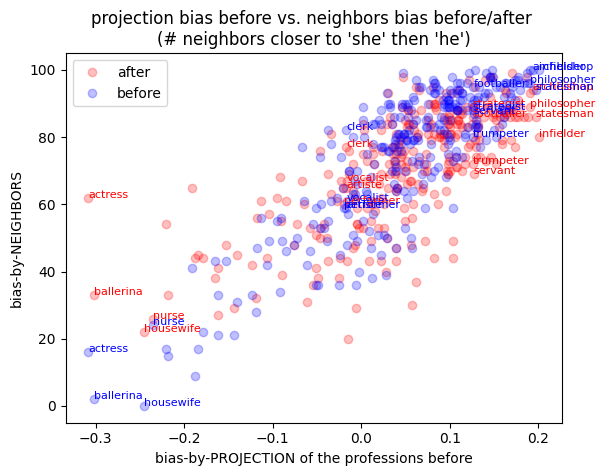

Correlation before: 0.8524125248442984, p-value: 2.268078082472901e-83
Correlation after: 0.7163653000055623, p-value: 4.359227434863786e-47


In [25]:
bias_by_profession(model, model_cleaned, gender_direction, P, None)

In [26]:
vecs.shape

(150000, 300)

### word association tests

In [27]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, model, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(model.similarity(w,a))
    for b in B:
        mean_b.append(model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, model, all_s_words):
    
    total = 0
    for x in X:
        x_sim = s_word(x, A, B, model, all_s_words)
        total += x_sim
    for y in Y:
        y_sim =  s_word(y, A, B, model, all_s_words)
        total -= y_sim
    
    #print(x_sim, y_sim)
        
    return total


def p_value_exhust(X, Y, A, B, model):
    
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, model, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    for subset in tqdm.tqdm_notebook(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    #print ('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, model):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, model, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [28]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print (p_value_exhust(A, B, C, D, model_cleaned))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print (p_value_exhust(A, B, E, F, model_cleaned))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print (p_value_exhust(A, B, G, H, model_cleaned))

/tmp/ipykernel_74904/280116927.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for subset in tqdm.tqdm_notebook(set(itertools.combinations(union, subset_size))):


  0%|          | 0/12870 [00:00<?, ?it/s]

0.6703962703962704


  0%|          | 0/12870 [00:00<?, ?it/s]

0.4881895881895882


  0%|          | 0/12870 [00:00<?, ?it/s]

0.8943278943278943


### Compare with debiasing on specific directions

In [29]:
#specific_words = [("he", "she"), ("man", "woman"), ("boy", "girl"), ("him", "her"), ("father", "mother"), ("king", "queen")]
specific_words = ["woman", "man"], ["girl", "boy"], ["she", "he"], ["mother", "father"], ["daughter", "son"], ["gal", "guy"], ["female", "male"], ["her", "his"], ["herself", "himself"], ["mary", "john"]

In [30]:
vecs_specific_words = np.array([ [model[p[1]] - model[p[0]]] for p in specific_words])
P_by_words = debias.debias_by_specific_directions(vecs_specific_words, 300) # projection matrix generated by zeroing the above directions
X_dev_cleaned = (P_by_words.dot(X_dev.T)).T
X_train_cleaned = (P_by_words.dot(X_train.T)).T

In [31]:
clf = LinearSVC(dual = False)
clf.fit(X_train_cleaned, Y_train)
print(clf.score(X_dev_cleaned, Y_dev))

0.8090310442144873


In [32]:
P, rowspace_projs, Ws = debias.get_debiasing_projection(gender_clf, params, len(specific_words), 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

clf = LinearSVC(dual = False)
clf.fit(P.dot(X_train.T).T, Y_train)
print(clf.score(P.dot(X_test.T).T, Y_test))

iteration: 9, accuracy: 0.5321417372216996: 100%|████| 10/10 [00:08<00:00,  1.20it/s]


0.5433667781493868


#### PCA (not in the paper)

In [33]:
""" 
gender_vecs = [model[p[0]] - model[p[1]] for p in specific_words]
pca = PCA(n_components=1)
pca.fit(gender_vecs)
gender_direction = pca.components_
P_by_words_pca = debias.debias_by_specific_directions(np.array([gender_direction]), 300) # projection matrix generated by zeroing the above directions
X_dev_cleaned_pca = (P_by_words_pca.dot(X_dev.T)).T
X_train_cleaned_pca = (P_by_words_pca.dot(X_train.T)).T
"""

' \ngender_vecs = [model[p[0]] - model[p[1]] for p in specific_words]\npca = PCA(n_components=1)\npca.fit(gender_vecs)\ngender_direction = pca.components_\nP_by_words_pca = debias.debias_by_specific_directions(np.array([gender_direction]), 300) # projection matrix generated by zeroing the above directions\nX_dev_cleaned_pca = (P_by_words_pca.dot(X_dev.T)).T\nX_train_cleaned_pca = (P_by_words_pca.dot(X_train.T)).T\n'

In [34]:
"""
clf = LinearSVC(dual = False)
clf.fit(X_train_cleaned_pca, Y_train)
print(clf.score(X_dev_cleaned_pca, Y_dev))
"""

'\nclf = LinearSVC(dual = False)\nclf.fit(X_train_cleaned_pca, Y_train)\nprint(clf.score(X_dev_cleaned_pca, Y_dev))\n'

A linear classifier is still able to recover the gender with non-random accuracy.

In [35]:
"""
M =  2000

#tsne_before = tsne_by_gender(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original")
X_dev_cleaned = (P_by_words.dot(X_dev.T)).T #X_dev.dot(P)
X_test_cleaned = (P_by_words.dot(X_test.T)).T #X_test.dot(P)
X_trained_cleaned = (P_by_words.dot(X_train.T)).T #X_train.dot(P)
all_significantly_biased_cleaned = P_by_words.dot(all_significantly_biased_vecs.T).T

tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M])))
print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M])))
"""

'\nM =  2000\n\n#tsne_before = tsne_by_gender(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original")\nX_dev_cleaned = (P_by_words.dot(X_dev.T)).T #X_dev.dot(P)\nX_test_cleaned = (P_by_words.dot(X_test.T)).T #X_test.dot(P)\nX_trained_cleaned = (P_by_words.dot(X_train.T)).T #X_train.dot(P)\nall_significantly_biased_cleaned = P_by_words.dot(all_significantly_biased_vecs.T).T\n\ntsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))\nprint("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M])))\nprint("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M])))\n'

In [36]:
model, model_cleaned

(<gensim.models.keyedvectors.Word2VecKeyedVectors at 0x12f52ffa0>,
 <gensim.models.keyedvectors.Word2VecKeyedVectors at 0x15d7bd580>)

In [37]:
w = "nurse"
w2 = "doctor"
v_w_before, v_w_after = model[w], model_cleaned[w]
v_w2_before, v_w2_after = model[w2], model_cleaned[w2]

In [38]:
np.linalg.norm(v_w_before-v_w2_before)

6.3952494

In [39]:
np.linalg.norm(v_w_after-v_w2_after)

5.2375426